# 1 - Introduction

Hi, I'm Naufal. This is the notebook for my first deep learning project. The dataset can be accessed here https://www.kaggle.com/datasets/blastchar/telco-customer-churn. I will design a deep learning model to predict if a customer will churn or not based on the provided information.

---
# 2 - Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import pickle

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, InputLayer, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report

---
# 3 - Data Loading

In [2]:
# set display options
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('telco_churn.csv')
data1 = data.copy()
print('Shape of the dataset (row, column) : ', data.shape)
data.head()

Shape of the dataset (row, column) :  (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Column explanation

* **CustomerID**: A unique ID that identifies each customer.

* **Gender**: The customer’s gender: Male, Female

* **SeniorCitizen**: Indicates if the customer is 65 or older: 1 = Yes, 0 = No

* **Partner**: Indicates if the customer has a partner: Yes, No

* **Dependents**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

* **Tenure**: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

* **PhoneService**: Indicates if the customer subscribes to home phone service with the company: Yes, No

* **MultipleLines**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No, No phone service

* **InternetService**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic.

* **OnlineSecurity**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

* **OnlineBackup**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

* **DeviceProtection**: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

* **TechSupport**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

* **StreamingTV**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

* **StreamingMovies**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

* **Contract**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

* **PaperlessBilling**: Indicates if the customer has chosen paperless billing: Yes, No

* **PaymentMethod**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

* **MonthlyCharge**: Indicates the customer’s current total monthly charge for all their services from the company.

* **TotalCharges**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

* **Churn**: Yes = the customer left the company this quarter. No = the customer remained with the company.

In [4]:
print('Number of missing value in the dataset : ',data.isnull().sum().sum())

Number of missing value in the dataset :  0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There are 21 columns in the dataset and most of them are categorical. The numerical columns are: SeniorCitizen, tenure, and MonthlyCharge.

In [6]:
data.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Turns out that SeniorCitizen is filled only with 0 and 1. Kinda similar to the other categorical columns which are filled with Yes and No.

For some reason, TotalCharges is filled with categorical values, instead of numerical. So, we will do a conversion.

In [7]:
# Convert string to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

Churn is our target variable. The model will be built to predict the churn of the customer.

---
# 4 - Exploratory Data Analysis (EDA)

### Descriptive Statistics

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


* On average, the customers have been with the company for 32 months.
* The average monthly charge is about $65.00.

In [9]:
data.describe(include=['O']).T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


* CustomerID is the unique identifier for each customer. It is not helpful to us for the model building.
* There are more male customers than female.
* Most of the customers use fiber optic for their internet service connection

### Categorical and Numerical Columns

In [10]:
# list of categorical and numerical columns
cat_col = data.select_dtypes(include=['object']).columns.to_list()
num_col = data.select_dtypes(exclude=['object']).columns.to_list()

print('Categorical columns : ',cat_col)
print('')
print('Numerical columns : ',num_col)

Categorical columns :  ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Numerical columns :  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


### Data Visualization

Skewness of column tenure : 0.2395397495619829
Skewness of column MonthlyCharges : -0.22052443394398033
Skewness of column TotalCharges : 0.961642499724251


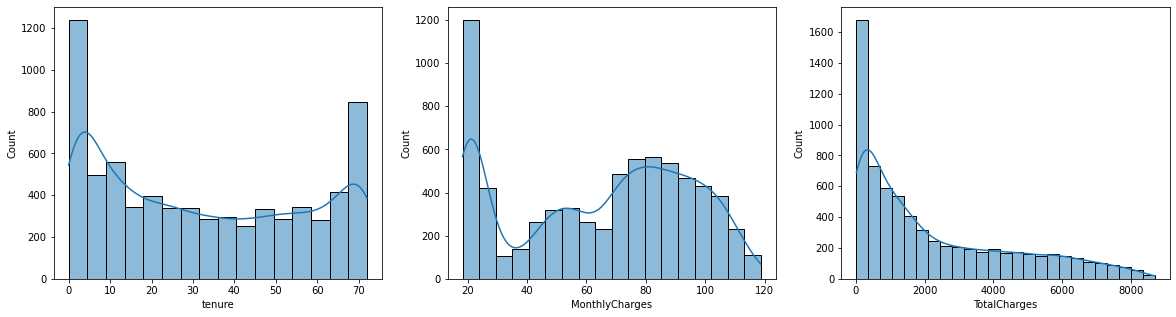

In [11]:
fig,axes=plt.subplots(1,3,figsize=(20,5))
i=0
for col in data[num_col].columns:
    if col == 'SeniorCitizen':
        continue
    sns.histplot(data=data, x=col,ax=axes[i], kde=True)
    skewness = data[col].skew()
    print('Skewness of column {} : {}'.format(col,skewness))
    i+=1

Both tenure and MonthlyCharges columns have fairly symmetrical distributions, but TotalCharges has a skewed distribution.

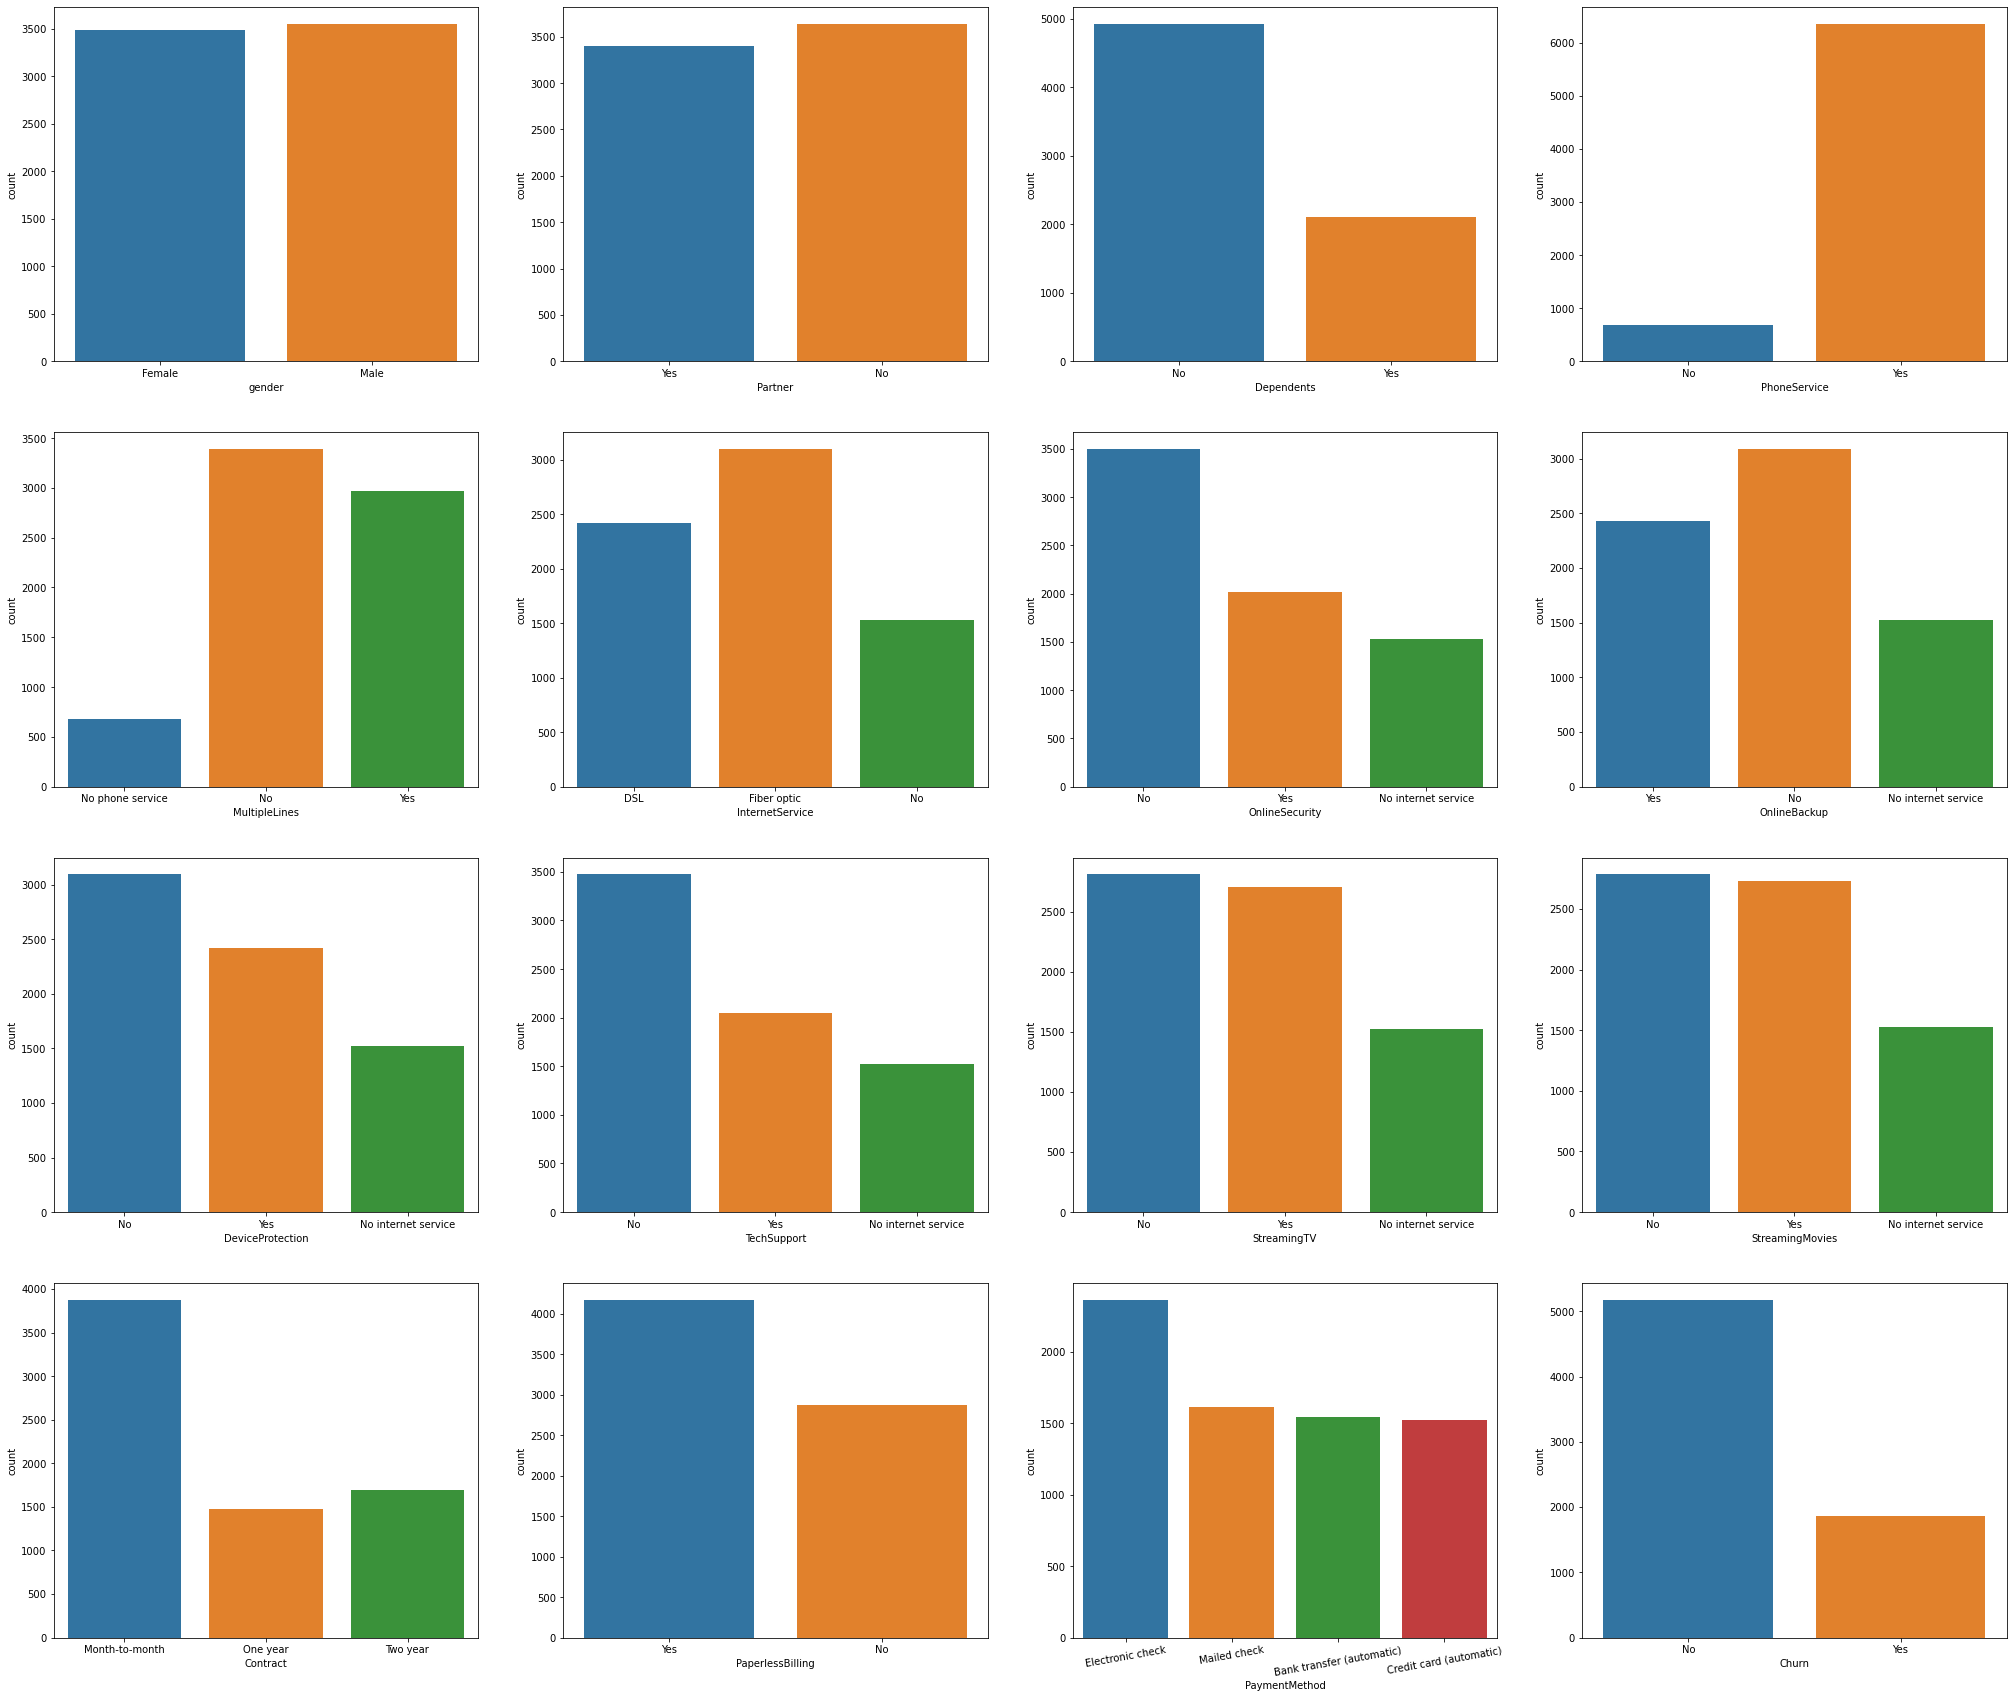

In [12]:
fig,axes=plt.subplots(4,4,figsize=(35,30))
i=0
j=0
for col in data1[cat_col].columns:
    if col == 'customerID' or col == 'TotalCharges':
        continue
    if col == 'PaymentMethod':
        sns.countplot(data=data1, x=col,ax=axes[i][j])
        axes[i][j].tick_params(axis='x', labelrotation=10)
    sns.countplot(data=data1, x=col,ax=axes[i][j])
    j+=1
    if j>3:
        j=0
        i+=1

* There is just a slight difference between the number of male and female customers, and customers with or without partners.
* The number of customers without dependent is about twice the number of customers with dependents
* Most of the customers are subscribed to phone service
* Payment method preferred by the customers is electronic check
* The number of churned customers is not even half of the not churned customers

---
# 5 - Data Preprocessing

First, we will drop CustomerID since it is not helpful in the model building.

In [13]:
data = data.drop(['customerID'],axis=1)

## 5.1 - Extract data for model inference

In [14]:
# Data for model inference
data_inf = data.sample(15, random_state=69) # extracting 15 rows randomly
data_inf.shape

(15, 20)

In [15]:
# remove the inference set from the original dataset
data_train_test = data.drop(data_inf.index)

# resetting index
data.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

## 5.2 - Split the dataset

In [16]:
# Split data into X (features) and y (target)
X = data_train_test.drop(['Churn'], axis=1)
y = data_train_test['Churn']

In [17]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # 70% training and 30% test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train) # 10% of training set is extracted for validation set
print('Train set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Validation set shape:', X_val.shape)

Train set shape: (4427, 19)
Test set shape: (2109, 19)
Validation set shape: (492, 19)


## 5.3 - Handling outlier

In [18]:
# numerical columns in the dataset
num_cols_train = X_train.select_dtypes(include=['int64', 'float64']).columns
num_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns
num_cols_val = X_val.select_dtypes(include=['int64', 'float64']).columns
print(num_cols_train)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


In [19]:
# skewness check in X_train
for col in num_cols_train:
    print('column X_train',col, ' skewness is :', X_train[col].skew())

column X_train SeniorCitizen  skewness is : 1.7739080674124035
column X_train tenure  skewness is : 0.22579623426051976
column X_train MonthlyCharges  skewness is : -0.2034464804462888
column X_train TotalCharges  skewness is : 0.9555886313663317


In [20]:
# skewness check in X_test
for col in num_cols_test:
    print('column X_test',col, ' skewness is :', X_test[col].skew())

column X_test SeniorCitizen  skewness is : 1.942901098752084
column X_test tenure  skewness is : 0.252845748991482
column X_test MonthlyCharges  skewness is : -0.23342711692572615
column X_test TotalCharges  skewness is : 0.9744384199628097


In [21]:
# skewness check in X_val
for col in num_cols_val:
    print('column X_val',col, ' skewness is :', X_val[col].skew())

column X_val SeniorCitizen  skewness is : 1.939789768467475
column X_val tenure  skewness is : 0.29655768383819914
column X_val MonthlyCharges  skewness is : -0.3314157714049767
column X_val TotalCharges  skewness is : 0.9441579164368146


* Fairly symmetrical columns : tenure and MonthlyCharges
* Skewed column : SeniorCitizen and TotalCharges. But since SeniorCitizen is filled with binary values, we will ignore the outliers in this column.

In [22]:
# function to find outliers in skewed columns
def find_outliers_skew(df, cols):
    q1, q3 = np.percentile(df[cols], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return df[cols][(df[cols] < lower_bound) | (df[cols] > upper_bound)]

#function to find outliers in normal columns
def find_outliers_normal(df, cols):
    out1 = df[cols].mean() + 3*df[cols].std()
    out2 = df[cols].mean() - 3*df[cols].std()
    return df[cols][(df[cols] > out1) | (df[cols] < out2)]

In [23]:
# X_train outliers
# normal columns
norm_cols_train = X_train[['tenure', 'MonthlyCharges', 'TotalCharges']].columns

for col in norm_cols_train:
    percentage = find_outliers_normal(X_train, col).shape[0] / X_train.shape[0] * 100
    print(f'Percentage of outliers in X_train {col} : ', percentage)

Percentage of outliers in X_train tenure :  0.0
Percentage of outliers in X_train MonthlyCharges :  0.0
Percentage of outliers in X_train TotalCharges :  0.0


In [24]:
norm_cols_val = X_val[['tenure', 'MonthlyCharges', 'TotalCharges']].columns

for col in norm_cols_val:
    percentage = find_outliers_normal(X_val, col).shape[0] / X_val.shape[0] * 100
    print(f'Percentage of outliers in X_val {col} : ', percentage)

Percentage of outliers in X_val tenure :  0.0
Percentage of outliers in X_val MonthlyCharges :  0.0
Percentage of outliers in X_val TotalCharges :  0.0


In [25]:
norm_cols_test = X_test[['tenure', 'MonthlyCharges', 'TotalCharges']].columns

for col in norm_cols_test:
    percentage = find_outliers_normal(X_test, col).shape[0] / X_test.shape[0] * 100
    print(f'Percentage of outliers in X_test {col} : ', percentage)

Percentage of outliers in X_test tenure :  0.0
Percentage of outliers in X_test MonthlyCharges :  0.0
Percentage of outliers in X_test TotalCharges :  0.0


It turns out that there is no outlier in the dataset

## 5.4 - Handling missing values

In [26]:
print('Missing values in X_train : ', X_train.isnull().sum().sum())
print('Missing values in X_test : ', X_test.isnull().sum().sum())
print('Missing values in X_val : ', X_val.isnull().sum().sum())
print('Missing values in y_train : ', y_train.isnull().sum().sum())
print('Missing values in y_test : ', y_test.isnull().sum().sum())
print('Missing values in y_val : ', y_val.isnull().sum().sum())

Missing values in X_train :  8
Missing values in X_test :  3
Missing values in X_val :  0
Missing values in y_train :  0
Missing values in y_test :  0
Missing values in y_val :  0


In [27]:
X_train.isnull().sum().sort_values(ascending=False)

TotalCharges        8
DeviceProtection    0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
gender              0
SeniorCitizen       0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
OnlineBackup        0
dtype: int64

In [28]:
X_test.isnull().sum().sort_values(ascending=False)

TotalCharges        3
DeviceProtection    0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
gender              0
SeniorCitizen       0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
OnlineBackup        0
dtype: int64

We will just remove the missing values since they are just a few.

In [29]:
# remove missing values
X_train = X_train.dropna()
X_test = X_test.dropna()

In [30]:
# remove corresponding rows in y_train and y_test
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [31]:
print('Missing values in X_train : ', X_train.isnull().sum().sum())
print('Missing values in X_test : ', X_test.isnull().sum().sum())
print('Missing values in X_val : ', X_val.isnull().sum().sum())
print('Missing values in y_train : ', y_train.isnull().sum().sum())
print('Missing values in y_test : ', y_test.isnull().sum().sum())
print('Missing values in y_val : ', y_val.isnull().sum().sum())

Missing values in X_train :  0
Missing values in X_test :  0
Missing values in X_val :  0
Missing values in y_train :  0
Missing values in y_test :  0
Missing values in y_val :  0


## 5.5 - Feature Selection

In [32]:
# categorical columns 
catcols = X_train.select_dtypes(include=['object']).columns
print('Categorical columns : ',catcols)
print(' ')
# numerical columns 
numcols = X_train.select_dtypes(include=['int64', 'float64']).columns
print('Numerical columns : ',numcols)

Categorical columns :  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
 
Numerical columns :  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


<AxesSubplot:>

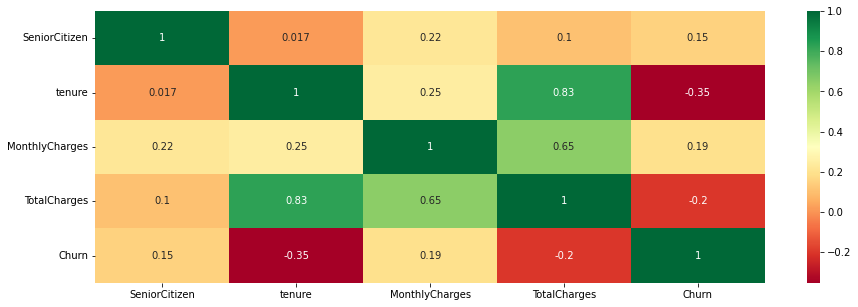

In [33]:
# check correlation between numerical columns and target 
enc = LabelEncoder()

df_num = pd.concat([data[numcols], data['Churn']], axis=1)
for col in df_num.select_dtypes(include=['object']).columns:
    df_num[col] = enc.fit_transform(df_num[col])

plt.figure(figsize=(15, 5))
sns.heatmap(df_num.corr(), annot=True, cmap='RdYlGn')

We can arguably say that all of the numerical columns have some correlation to the target column.

<AxesSubplot:>

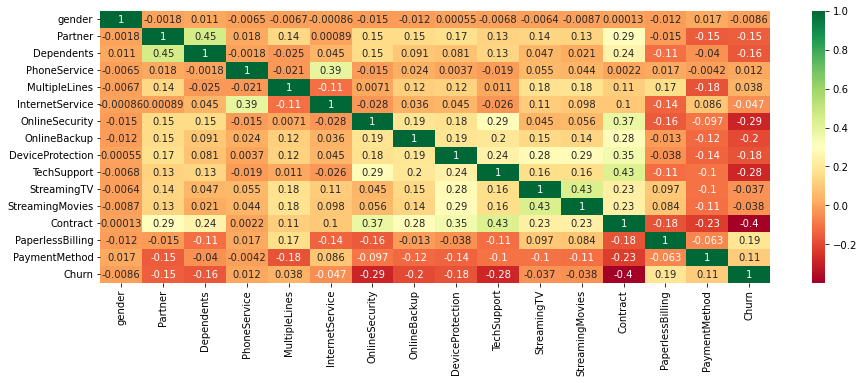

In [34]:
# check correlation between catgeorical columns and target 
df_cat = pd.concat([data[catcols], data['Churn']], axis=1)
for col in df_cat.select_dtypes(include=['object']).columns:
    df_cat[col] = enc.fit_transform(df_cat[col])

plt.figure(figsize=(15, 5))
sns.heatmap(df_cat.corr(), annot=True, cmap='RdYlGn')

Again, we can say that all of the categorical columns have some correlation to the target column.

## 5.6 - Split between numerical and categorical features

In [35]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns :  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [36]:
# Split Train-Set and Test-Set based on Column Type (Numerical/Categorical)
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_val_num = X_val[num_columns]
X_val_cat = X_val[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

## 5.7 - Feature scaling

In [37]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [38]:
# save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [39]:
# converting back to dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns=X_val_num.columns)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

## 5.8 - Feature encoding

In [40]:
unique_val = pd.unique(X_train_cat.values.ravel()) # get all unique values

ohe = OneHotEncoder(categories=[unique_val]*X_train_cat.shape[1], sparse=False, handle_unknown='ignore', drop='first') # drop first to avoid dummy variable trap

ohe.fit(X_train_cat)

X_train_cat_ohe = ohe.transform(X_train_cat)
X_val_cat_ohe = ohe.transform(X_val_cat)
X_test_cat_ohe = ohe.transform(X_test_cat)

In [41]:
# save ohe
with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)

In [42]:
# convert back to dataframe
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe)
X_val_cat_ohe = pd.DataFrame(X_val_cat_ohe)
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe)

## 5.9 - Target encoding

In [43]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_val = enc.transform(y_val)
y_test = enc.transform(y_test)

## 5.10 - Concatenate all

In [44]:
# concatenate all
X_train_final = pd.concat([X_train_num_scaled, X_train_cat_ohe], axis=1)
X_val_final = pd.concat([X_val_num_scaled, X_val_cat_ohe], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis=1)

## 5.11 - Dimensionality reduction

In [45]:
X_train_final.shape

(4419, 214)

As we can see above, our training set has 214 features. It is definitely not good for the model building. So, we will do dimensionality reduction with PCA.

### 5.11.1 - PCA

In [46]:
pca = PCA()
pca.fit(X_train_final)

PCA()

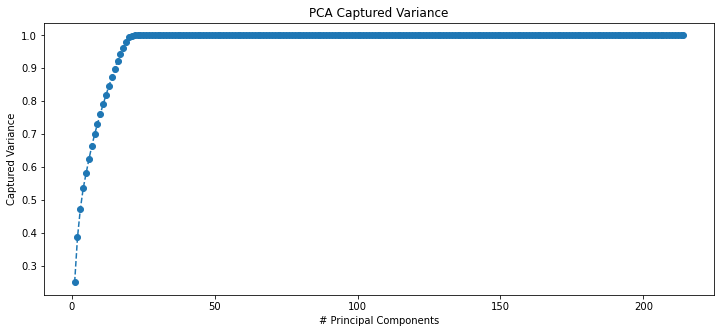

In [48]:
plt.figure(figsize=(12,5))
plt.plot(range(1, 215), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', )
plt.title('PCA Captured Variance')
plt.xlabel('# Principal Components')
plt.ylabel('Captured Variance')
plt.show()

In order to capture about 95% of the variance, we will use 18 number of principal components.

In [49]:
pca18 = PCA(n_components=18)
pca18.fit(X_train_final)

PCA(n_components=18)

In [81]:
# save PCA
with open('pca18.pkl', 'wb') as f:
    pickle.dump(pca18, f)

In [50]:
pca18.explained_variance_ratio_

array([0.24859297, 0.1370448 , 0.08646217, 0.06260238, 0.04535053,
       0.04290836, 0.04047314, 0.03552744, 0.03265806, 0.03045522,
       0.02914648, 0.02826505, 0.02675258, 0.02562708, 0.02513849,
       0.02481954, 0.02218974, 0.01864829])

In [51]:
pca18_train = pca18.transform(X_train_final)
pca18_val = pca18.transform(X_val_final)
pca18_test = pca18.transform(X_test_final)

In [80]:
pca18_test

array([[-0.97070306, -1.29959277, -0.54774326, ..., -0.52241518,
         0.01012072, -0.29343307],
       [-0.48547849, -0.68182354,  1.0663125 , ..., -0.4734952 ,
        -0.8745342 ,  0.66084482],
       [-0.87387427,  1.57998361, -1.06492867, ..., -0.62644933,
        -0.43427972,  0.20448381],
       ...,
       [-0.96535963, -1.13903289, -0.4705652 , ...,  0.01082222,
        -0.74925952,  0.02746217],
       [-0.2790605 ,  0.61711366,  0.8868758 , ...,  0.67902326,
         0.75837436,  0.25983223],
       [-0.04185909,  0.70894549,  2.64550499, ...,  0.16712092,
        -0.56840808, -0.48622965]])

In [52]:
pca18_train_df = pd.DataFrame(pca18_train, columns=['PCA_'+str(i) for i in range(1,19)])
pca18_train_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
0,3.064905,0.227169,0.226015,-0.819756,0.343968,0.244835,-0.153850,0.090167,-0.108307,-0.233356,0.409485,0.059784,-0.353307,-0.011641,-0.092692,-0.190414,0.176222,0.447618
1,-0.384337,-1.137178,1.192571,0.341521,-0.270717,0.615384,-0.396772,-0.191434,0.264193,-0.083850,-0.582997,-0.758739,1.464070,-0.030819,-0.366872,-0.111336,-0.546995,0.541597
2,2.976078,0.367497,0.169316,-0.811806,0.238667,0.245625,-0.118757,0.015474,0.046100,-0.285794,0.450817,-0.218339,-0.262305,0.368149,0.734985,-0.173515,-0.477264,-0.079894
3,-1.311578,-0.632957,-1.158527,0.263725,0.148600,0.242691,0.389302,-0.331322,0.718014,0.233382,-0.262580,1.058916,0.034086,0.696636,-0.308159,0.171450,-0.205247,0.195939
4,-0.180399,2.120163,1.369221,1.154296,0.467301,0.406343,0.653127,0.631825,0.075642,0.330586,-0.920256,-0.462995,-0.544454,-0.281859,-0.322541,-0.506805,-0.155967,-0.413898


## 5.12 - Oversampling

In [53]:
y_train_df = pd.DataFrame(y_train, columns=['Churn'])
y_train_df.value_counts()

Churn
0        3245
1        1174
dtype: int64

We can see that the target is a little bit imbalanced. We will do oversampling to balance the dataset.

In [54]:
# SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=3).fit_resample(pca18_train_df, y_train_df) # Minority Class will have same the same number as the majority class
# X_resampled, y_resampled = SMOTE(sampling_strategy={"Fraud":1000}).fit_resample(X, y) # Minority Class will have 1000 data
X_resampled = pd.DataFrame(X_resampled, columns=pca18_train_df.columns)
y_resampled.value_counts()

Churn
0        3245
1        3245
dtype: int64

---
# 6 - Model Definition

## Model 1

In [55]:
# Sequential API
model = Sequential()
model.add(InputLayer(input_shape=(18,)))
model.add(Dense(24, activation='relu', kernel_initializer='glorot_normal')) 
model.add(BatchNormalization()) 
model.add(Dropout(0.3))
model.add(Dense(18, activation='relu'))  
model.add(Dropout(0.3))
model.add(Dense(6, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  

# compile
model.compile(loss='binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(lr=0.001),           
              metrics =['accuracy'])

## Model 2

In [56]:
# Functional API
data_in = Input(shape=(18,))
hidden_1 = Dense(24, activation='relu')(data_in)   
hidden_drop_1 = Dropout(0.3)(hidden_1)
hidden_2 = Dense(4, activation='relu')(hidden_drop_1)  
hidden_drop_2 = Dropout(0.3)(hidden_2)
out = Dense(1, activation='sigmoid')(hidden_drop_2)    

model2 = Model(inputs=data_in, outputs=out)

# compile
model2.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.001),           
              metrics =['accuracy'])

---
# 7 - Model Training

In [57]:
# setting number of epoch and callback for early stopping
num_epoch = 100
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # early stopping set after 5 epochs

## Model 1

In [58]:
history = model.fit(X_resampled, y_resampled, epochs=num_epoch, callbacks=[stop_early], validation_data=(pca18_val, y_val)) 

Epoch 1/100
203/203 [==============================] - 3s 5ms/step - loss: 0.6610 - accuracy: 0.6439 - val_loss: 0.6326 - val_accuracy: 0.6321
Epoch 2/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5692 - accuracy: 0.7210 - val_loss: 0.5625 - val_accuracy: 0.6931
Epoch 3/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7324 - val_loss: 0.5418 - val_accuracy: 0.7053
Epoch 4/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.7370 - val_loss: 0.5326 - val_accuracy: 0.7154
Epoch 5/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5349 - accuracy: 0.7441 - val_loss: 0.5396 - val_accuracy: 0.7053
Epoch 6/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.7487 - val_loss: 0.5432 - val_accuracy: 0.7053
Epoch 7/100
203/203 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7532 - val_loss: 0.5401 - val_accuracy: 0.7114

## Model 2

In [59]:
history2 = model2.fit(X_resampled, y_resampled, epochs=num_epoch, callbacks=[stop_early], validation_data=(pca18_val, y_val)) 

Epoch 1/100
203/203 [==============================] - 1s 3ms/step - loss: 0.6288 - accuracy: 0.6231 - val_loss: 0.5864 - val_accuracy: 0.6707
Epoch 2/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.6915 - val_loss: 0.5581 - val_accuracy: 0.6951
Epoch 3/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5494 - accuracy: 0.7233 - val_loss: 0.5607 - val_accuracy: 0.6890
Epoch 4/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5372 - accuracy: 0.7291 - val_loss: 0.5344 - val_accuracy: 0.7093
Epoch 5/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5286 - accuracy: 0.7356 - val_loss: 0.5285 - val_accuracy: 0.7134
Epoch 6/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7348 - val_loss: 0.5438 - val_accuracy: 0.6951
Epoch 7/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5242 - accuracy: 0.7407 - val_loss: 0.5418 - val_accuracy: 0.6972

---
# 8 - Model Evaluation

## Model 1

Model 1 architecture is summarized as follows:

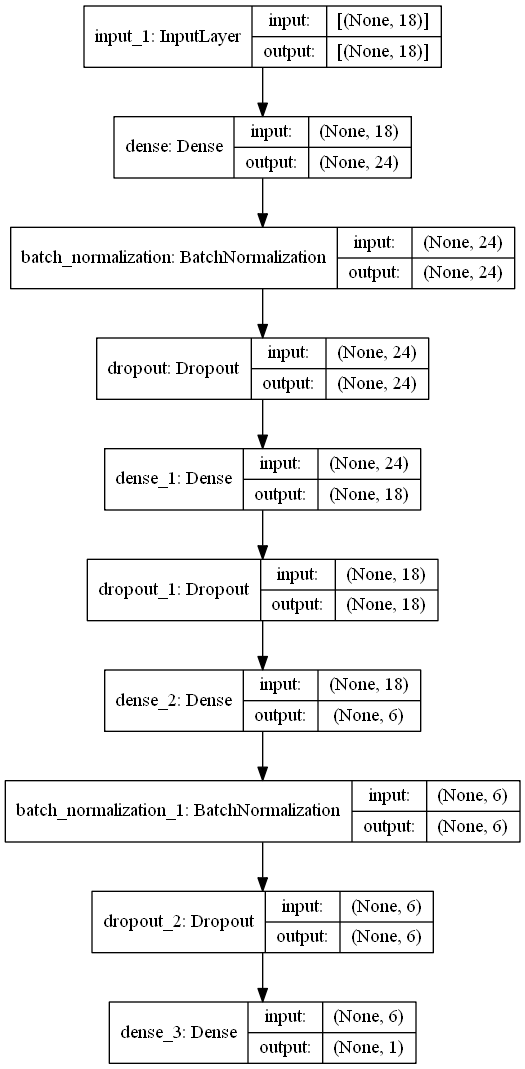

In [60]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [61]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
4,0.534857,0.744068,0.539598,0.705285
5,0.529902,0.748690,0.543172,0.705285
6,0.525487,0.753159,0.540050,0.711382
7,0.519163,0.754237,0.532858,0.715447
8,0.517439,0.753929,0.534307,0.711382


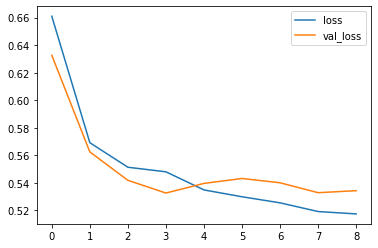

In [62]:
metrics[['loss', 'val_loss']].plot();

Model 1 is overfitted. Loss in training is decreasing but loss in validation is increasing.

In [63]:
y_pred = model.predict(pca18_test)
y_pred = np.where(y_pred >= 0.5,1,0)  
y_pred.shape

(2106, 1)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1546
           1       0.49      0.82      0.61       560

    accuracy                           0.72      2106
   macro avg       0.70      0.75      0.70      2106
weighted avg       0.80      0.72      0.74      2106



Overall, model 1 has accuracy of 73% and weighted f1-score of 74%. It has high precision score when considering 0 as the positive class (91%), but low precision when considering 1 as the positive class (49%). It means that the model has higher False Positives. A situation where the model predicts a customer will leave the company but the actual value is that the customer will stay.

## Model 2

Model 2 architecture is summarized as follows:

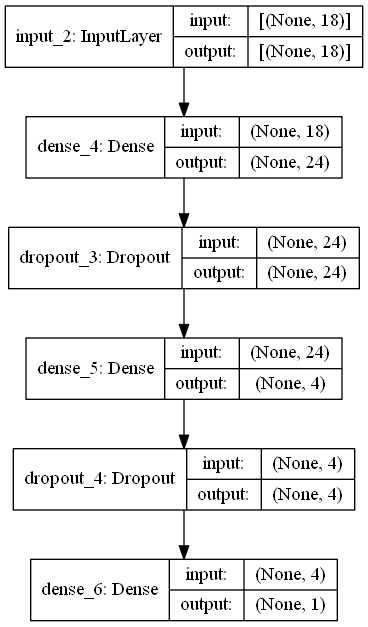

In [65]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [66]:
metrics = pd.DataFrame(history2.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.525645,0.734823,0.543773,0.695122
6,0.524179,0.740678,0.541787,0.697154
7,0.525994,0.738983,0.536520,0.701219
8,0.527362,0.738521,0.534588,0.707317
9,0.519052,0.739137,0.536351,0.705285


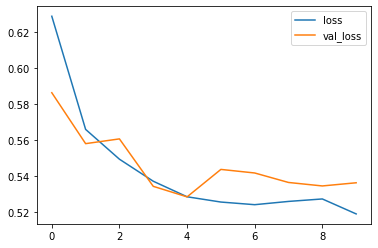

In [67]:
metrics[['loss', 'val_loss']].plot();

Model 2 is also overfitted. The loss in trainig and validation are not moving in the same direction.

In [68]:
y_pred = model2.predict(pca18_test)
y_pred = np.where(y_pred >= 0.5,1,0) 
y_pred.shape

(2106, 1)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1546
           1       0.48      0.80      0.60       560

    accuracy                           0.72      2106
   macro avg       0.69      0.75      0.69      2106
weighted avg       0.79      0.72      0.74      2106



Similar situation with model 1. It has high precision score when considering 0 as the positive class (91%), but low precision when considering 1 as the positive class (49%).

The only difference is that model 2 has a slightly lower accuracy with 72%.

## Model 1 vs Model 2

In [70]:
eval_dict = model.evaluate(pca18_test, y_test, return_dict=True)
eval_dict2 = model2.evaluate(pca18_test, y_test, return_dict=True)
print('Model 1 Loss: {}'.format(np.around(eval_dict['loss'], decimals=3)))
print('Model 1 Accuracy: {}'.format(np.around(eval_dict['accuracy'], decimals=3)))
print('')
print('Model 2 Loss: {}'.format(np.around(eval_dict2['loss'], decimals=3)))
print('Model 2 Accuracy: {}'.format(np.around(eval_dict2['accuracy'], decimals=3)))

66/66 [==============================] - 0s 1ms/step - loss: 0.5012 - accuracy: 0.7194
Model 1 Loss: 0.502
Model 1 Accuracy: 0.723

Model 2 Loss: 0.501
Model 2 Accuracy: 0.719


There is just a tiny bit difference between the two models. Model 1 has slightly better accuracy but it also has a higher loss.

## Model improvement

We will create a new model by tuning 4 hyperparameters : 
* number of hidden layers : 3 to 4 
* number of neurons in each layer : from 2 to 26 with step of 8 
* dropout percentage : 0.3 to 0.5 with step of 0.1
* learning rate of the optimizer : 0.01, 0.001, and 0.0001

In [71]:
# model builder function
def build_model(hp):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(18,)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 3 - 4
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 3, 5)):
        model.add(
            Dense(
                units=hp.Int("units_" + str(i), min_value=2, max_value=26, step=8),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0.3 - 0.5 with stepsize of 0.1.
        model.add(Dropout(hp.Float("dropout_" + str(i), 0.3, 0.5, step=0.1)))
    
    # Add output layer.
    model.add(Dense(units=1, activation="sigmoid"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    
    return model

In [72]:
# Initiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=100,
                     factor=3,
                     hyperband_iterations=3,
                     directory="kt_dir",
                     project_name="kt_hyperband", overwrite=True)

In [73]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 26, 'step': 8, 'sampling': None}
dropout_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 26, 'step': 8, 'sampling': None}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [74]:
num_epoch = 100
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) 

In [76]:
# start the tuning
tuner.search(X_resampled, y_resampled, epochs=num_epoch, callbacks=[stop_early], validation_data=(pca18_val, y_val)) 

Trial 508 Complete [00h 00m 27s]
val_accuracy: 0.7337398529052734

Best val_accuracy So Far: 0.8109756112098694
Total elapsed time: 02h 26m 14s

Search: Running Trial #509

Hyperparameter    |Value             |Best Value So Far 
num_layers        |4                 |4                 
units_1           |18                |2                 
dropout_1         |0.4               |0.5               
units_2           |10                |18                
dropout_2         |0.4               |0.4               
learning_rate     |0.01              |0.01              
units_3           |10                |2                 
dropout_3         |0.5               |0.4               
units_4           |18                |26                
dropout_4         |0.4               |0.4               
tuner/epochs      |100               |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |0                 |4                 
tuner/round       |0         

UnknownError: Failed to rename: kt_dir\kt_hyperband\trial_b217790de2489ced6facac9ccab53da1\checkpoints\epoch_0\checkpoint.tmp4848215c4eac44809ce9444c33e37ed5 to: kt_dir\kt_hyperband\trial_b217790de2489ced6facac9ccab53da1\checkpoints\epoch_0\checkpoint : Access is denied.
; Input/output error

note: tuning took about 98 minutes

In [ ]:
# Get the optimal hyperparameters from the results
best_hp=tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'num_layers': 4, 'units_1': 18, 'dropout_1': 0.3, 'units_2': 2, 'dropout_2': 0.4, 'learning_rate': 0.01, 'units_3': 18, 'dropout_3': 0.3, 'units_4': 2, 'dropout_4': 0.3, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 4, 'tuner/round': 3, 'tuner/trial_id': '3aa72b50ab7e3ed9e5e8b6e2c9ca268c'}


The optimal hyperparameters are:
* number of hidden layers = 4
* number of neurons in the first hidden layer = 18
* number of neurons in the second hidden layer = 2
* number of neurons in the third hidden layer = 18
* number of neurons in the fourth hidden layer = 2
* dropout percentage = 0.3 and 0.4 in the last dropout
* learning rate of the optimizer = 0.01

In [ ]:
# Build a model based on the optimal hyperparameters
tuned_model = tuner.hypermodel.build(best_hp)

# Train the hypertuned model
tuned_model.fit(X_resampled, y_resampled, epochs=num_epoch, callbacks=[stop_early], validation_data=(pca18_val, y_val)) 

Epoch 1/100
203/203 [==============================] - 1s 3ms/step - loss: 0.6265 - accuracy: 0.6786 - val_loss: 0.5602 - val_accuracy: 0.7744
Epoch 2/100
203/203 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.7023 - val_loss: 0.5550 - val_accuracy: 0.7724
Epoch 3/100
203/203 [==============================] - 0s 1ms/step - loss: 0.5942 - accuracy: 0.7116 - val_loss: 0.5473 - val_accuracy: 0.7520
Epoch 4/100
203/203 [==============================] - 0s 1ms/step - loss: 0.5859 - accuracy: 0.7211 - val_loss: 0.5390 - val_accuracy: 0.7622
Epoch 5/100
203/203 [==============================] - 0s 1ms/step - loss: 0.5820 - accuracy: 0.7254 - val_loss: 0.5288 - val_accuracy: 0.7520
Epoch 6/100
203/203 [==============================] - 0s 1ms/step - loss: 0.5841 - accuracy: 0.7293 - val_loss: 0.5668 - val_accuracy: 0.7378
Epoch 7/100
203/203 [==============================] - 0s 1ms/step - loss: 0.5912 - accuracy: 0.7205 - val_loss: 0.5473 - val_accuracy: 0.7520

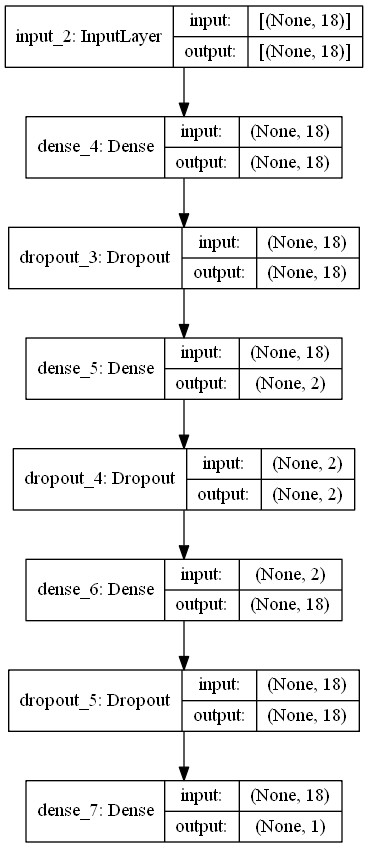

In [ ]:
tf.keras.utils.plot_model(tuned_model, show_shapes=True)

In [ ]:
eval_dict = tuned_model.evaluate(pca18_test, y_test, return_dict=True)
print('Tuned model Loss: {}'.format(np.around(eval_dict['loss'], decimals=3)))
print('Tuned model Accuracy: {}'.format(np.around(eval_dict['accuracy'], decimals=3)))

66/66 [==============================] - 0s 723us/step - loss: 0.5546 - accuracy: 0.7441
Tuned model Loss: 0.555
Tuned model Accuracy: 0.744


The tuned model has significantly better accuracy than the previous two models, 74% compared to 72.5% and 72.1%.

---
# 9 - Model Saving

In [ ]:
tuned_model.save('tuned_model.h5')

In [77]:
# model.save('model1.h5')

---
# 10 - Model Inference

In [ ]:
print('Data inference shape : ',data_inf.shape)
data_inf.head()

Data inference shape :  (15, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,Yes,18,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),24.65,471.35,No
1,Female,0,Yes,Yes,25,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.10,486.05,No
2,Male,0,No,Yes,1,Yes,No,DSL,Yes,Yes,No,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),70.45,70.45,No
3,Female,0,Yes,Yes,63,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,19.35,1263.85,No
4,Male,0,No,No,10,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.35,176.30,No


In [ ]:
data_inf.isnull().sum().sum()

0

In [ ]:
# Split between Numerical Columns and Categorical Columns
data_inf_num = data_inf[num_columns]
data_inf_cat = data_inf[cat_columns]

In [ ]:
# feature scaling
data_inf_num_scaled = scaler.transform(data_inf_num)

In [ ]:
# converting back to dataframe
data_inf_num_scaled = pd.DataFrame(data_inf_num_scaled, columns=data_inf_num.columns)

In [ ]:
# feature encoding
data_inf_cat_ohe = ohe.transform(data_inf_cat)

In [ ]:
# convert back to dataframe
data_inf_cat_ohe = pd.DataFrame(data_inf_cat_ohe)

#get column names
data_inf_cat_ohe.columns = ohe.get_feature_names_out(input_features=data_inf_cat.columns)

In [ ]:
# concatenate all columns
data_inf_final = pd.concat([data_inf_num_scaled, data_inf_cat_ohe], axis=1)

In [ ]:
print('Data inference shape : ',data_inf_final.shape)
data_inf_final.head()

Data inference shape :  (15, 214)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Yes,gender_No,gender_No internet service,gender_Two year,gender_Mailed check,gender_Female,gender_DSL,gender_One year,gender_Bank transfer (automatic),gender_Credit card (automatic),gender_Fiber optic,gender_Month-to-month,gender_Electronic check,gender_No phone service,Partner_Yes,Partner_No,Partner_No internet service,Partner_Two year,Partner_Mailed check,Partner_Female,Partner_DSL,Partner_One year,Partner_Bank transfer (automatic),Partner_Credit card (automatic),Partner_Fiber optic,Partner_Month-to-month,Partner_Electronic check,Partner_No phone service,Dependents_Yes,Dependents_No,Dependents_No internet service,Dependents_Two year,Dependents_Mailed check,Dependents_Female,Dependents_DSL,Dependents_One year,Dependents_Bank transfer (automatic),Dependents_Credit card (automatic),Dependents_Fiber optic,Dependents_Month-to-month,Dependents_Electronic check,Dependents_No phone service,PhoneService_Yes,PhoneService_No,PhoneService_No internet service,PhoneService_Two year,PhoneService_Mailed check,PhoneService_Female,PhoneService_DSL,PhoneService_One year,PhoneService_Bank transfer (automatic),PhoneService_Credit card (automatic),PhoneService_Fiber optic,PhoneService_Month-to-month,PhoneService_Electronic check,PhoneService_No phone service,MultipleLines_Yes,MultipleLines_No,MultipleLines_No internet service,MultipleLines_Two year,MultipleLines_Mailed check,MultipleLines_Female,MultipleLines_DSL,MultipleLines_One year,MultipleLines_Bank transfer (automatic),MultipleLines_Credit card (automatic),MultipleLines_Fiber optic,MultipleLines_Month-to-month,MultipleLines_Electronic check,MultipleLines_No phone service,InternetService_Yes,InternetService_No,InternetService_No internet service,InternetService_Two year,InternetService_Mailed check,InternetService_Female,InternetService_DSL,InternetService_One year,InternetService_Bank transfer (automatic),InternetService_Credit card (automatic),InternetService_Fiber optic,InternetService_Month-to-month,InternetService_Electronic check,InternetService_No phone service,OnlineSecurity_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Two year,OnlineSecurity_Mailed check,OnlineSecurity_Female,OnlineSecurity_DSL,OnlineSecurity_One year,OnlineSecurity_Bank transfer (automatic),OnlineSecurity_Credit card (automatic),OnlineSecurity_Fiber optic,OnlineSecurity_Month-to-month,OnlineSecurity_Electronic check,OnlineSecurity_No phone service,OnlineBackup_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Two year,OnlineBackup_Mailed check,OnlineBackup_Female,OnlineBackup_DSL,OnlineBackup_One year,OnlineBackup_Bank transfer (automatic),OnlineBackup_Credit card (automatic),OnlineBackup_Fiber optic,OnlineBackup_Month-to-month,OnlineBackup_Electronic check,OnlineBackup_No phone service,DeviceProtection_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Two year,DeviceProtection_Mailed check,DeviceProtection_Female,DeviceProtection_DSL,DeviceProtection_One year,DeviceProtection_Bank transfer (automatic),DeviceProtection_Credit card (automatic),DeviceProtection_Fiber optic,DeviceProtection_Month-to-month,DeviceProtection_Electronic check,DeviceProtection_No phone service,TechSupport_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Two year,TechSupport_Mailed check,TechSupport_Female,TechSupport_DSL,TechSupport_One year,TechSupport_Bank transfer (automatic),TechSupport_Credit card (automatic),TechSupport_Fiber optic,TechSupport_Month-to-month,TechSupport_Electronic check,TechSupport_No phone service,StreamingTV_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Two year,StreamingTV_Mailed check,StreamingTV_Female,StreamingTV_DSL,StreamingTV_One year,StreamingTV_Bank transfer (automatic),StreamingTV_Credit card (automatic),StreamingTV_Fiber optic,StreamingTV_Month-to-month,StreamingTV_Electronic check,StreamingTV_No phone service,StreamingMovies_Yes,StreamingMovies_No

In [ ]:
# dimensionality reduction
data_inf_final_pca18 = pca18.transform(data_inf_final)

In [ ]:
data_inf_final_pca18_df = pd.DataFrame(data_inf_final_pca18, columns=['PCA_'+str(i) for i in range(1,19)])
data_inf_final_pca18_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
0,2.433494,0.813975,-0.557431,-0.971321,-0.339032,-0.757018,0.949942,-0.470069,-0.019983,-0.034172,-0.207864,0.452345,0.141267,0.239287,0.806899,0.007792,-0.286414,0.081810
1,3.060156,0.289950,0.217901,-0.824417,0.296968,0.222880,-0.154919,0.075824,-0.127195,0.045244,-0.454508,0.314839,-0.124569,-0.032390,0.100581,-0.107372,0.159135,0.508607
2,-0.382558,0.041753,1.100562,0.198637,0.021230,-1.100290,-0.863264,0.037658,-1.176857,0.178953,0.432488,0.477604,-0.218322,0.715916,-1.010077,-0.704818,-0.450224,-0.609276
3,2.823593,0.411128,-0.036118,-0.912401,0.309227,0.340015,-0.022173,0.223306,-0.048177,0.232612,-0.484785,0.120556,-0.439291,-0.042646,0.142967,0.462542,-0.979252,0.472384
4,2.792044,-0.722700,-0.212381,0.856656,0.031959,0.222690,-0.305122,0.174869,0.006875,-0.018222,0.536673,-0.325474,0.487461,0.003226,-0.379538,0.522555,0.496151,0.079405


In [ ]:
# get prediction
y_pred_inf = tuned_model.predict(data_inf_final_pca18)
y_pred_inf = np.where(y_pred_inf >= 0.5,1,0)

In [ ]:
# convert to dataframe
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Churn-Pred'])

In [ ]:
data_inf1 = data_inf.copy()
data_inf1['Churn'] = data_inf1.Churn.replace({0: 'No', 1: 'Yes'})

In [ ]:
# concat prediction with real data 
print('Model prediction to new data')
final_log = pd.concat([data_inf1, y_pred_inf_df], axis=1)
final_log[['Churn', 'Churn-Pred']].head(10)

Model prediction to new data


,Churn,Churn-Pred
0,No,0
1,No,0
2,No,0
3,No,0
4,No,0
5,No,0
6,No,0
7,Yes,1
8,Yes,0
9,No,0


The model is able to predict new data. Based on the first 10 predictions as above, the model only gave 1 wrong prediction. In onther word, it has accuracy of 90%.

---
# 11 - Conclusions

We have made a model that can predict the churn of the customer based on a dataset with 7043 entries and 21 columns.

The dataset does not have any outlier and barely have missing values.

Scaler and encoder used were MinMaxScaler and OneHotEncoder.

After scaling and encoding, there were 214 features. So, we reduced the dimensionality with PCA. We were able to capture about 95% of the variance with 18 number of principal components.

Since the dataset is slightly imbalanced (there are more not churned compared to churned customers), we did oversampling to balance the dataset with SMOTE.

We made 3 ANN models. The first model has 3 hidden layers with additional dropout and batch normalization. The second model has only 2 hidden layers and dropouts. The third model was made with Keras Tuner using Hyperband algorithm. It has 4 hidden layers, dropouts, and the learning rate for adam optimizer was 0.001.

The third model, named tuned_model, performed the best with accuracy of 74% against test set. Furthermore, it was able to predict new data with only 1 wrong prediction out of 10 predictions.

The model can be further improved by tuning more hyperparameters, or by using different feature engineering techniques (e.g. scaler, encoder, PCA, etc.), and so on.